# Analysis of Generated Sequences

In [72]:
# !pip install levenshtein

In [91]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Levenshtein import distance as levenshtein_distance

In [92]:
def read_fasta(filepath):
    """Read sequences from a FASTA file."""
    sequences = []
    with open(filepath, 'r') as f:
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if seq:
                    sequences.append(seq)
                    seq = ""
            else:
                seq += line
        if seq:
            sequences.append(seq)
    return sequences

def calculate_similarity(seq1, seq2):
    """
    Calculate sequence similarity as 1 - (normalized edit distance).
    Returns a value between 0 (completely different) and 1 (identical).
    """
    max_len = max(len(seq1), len(seq2))
    if max_len == 0:
        return 1.0
    edit_dist = levenshtein_distance(seq1, seq2)
    similarity = 1 - (edit_dist / max_len)
    return similarity

## Temp = 1

In [93]:
# dir with generated seqs
aptamers = ["2AU4", "5KPY", "6E8T"]
base_dir = "./generated_seqs/"
fasta_dir = "./aptamers/fasta/"

In [94]:
results = []

# Process each aptamer
for aptamer in aptamers:
    # Read reference sequence
    ref_file = os.path.join(fasta_dir, f"{aptamer}.fasta")
    ref_seqs = read_fasta(ref_file)
    ref_seq = ref_seqs[0] if ref_seqs else ""
    
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate similarity for each generated sequence
    for i, gen_seq in enumerate(gen_seqs):
        similarity = calculate_similarity(ref_seq, gen_seq)
        results.append({
            'Aptamer': aptamer,
            'Sequence': i + 1,
            'Similarity': similarity
        })

# Create DataFrame
df = pd.DataFrame(results)

# Pivot to get desired format (rows = sequences, columns = aptamers)
df_pivot = df.pivot(index='Sequence', columns='Aptamer', values='Similarity')

print("Similarity Matrix:")
print(df_pivot)
print("\n")

# Calculate statistics
stats = df.groupby('Aptamer')['Similarity'].agg(['mean', 'std'])
print("Statistics by Aptamer:")
print(stats)
print("\n")



Similarity Matrix:
Aptamer       2AU4      5KPY      6E8T
Sequence                              
1         0.634146  0.774648  0.244755
2         0.609756  0.647887  0.223776
3         0.658537  0.788732  0.244755
4         0.463415  0.718310  0.251748
5         0.609756  0.774648  0.244755
6         0.463415  0.760563  0.237762
7         0.463415  0.746479  0.251748
8         0.414634  0.633803  0.230769
9         0.512195  0.661972  0.251748
10        0.536585  0.774648  0.244755
11        0.585366  0.718310  0.237762
12        0.585366  0.690141  0.237762
13        0.609756  0.760563  0.244755
14        0.536585  0.732394  0.244755
15        0.585366  0.704225  0.251748
16        0.439024  0.760563  0.237762
17        0.585366  0.760563  0.244755
18        0.487805  0.704225  0.251748
19        0.512195  0.690141  0.251748
20        0.536585  0.718310  0.244755


Statistics by Aptamer:
             mean       std
Aptamer                    
2AU4     0.541463  0.070156
5KPY     0.726

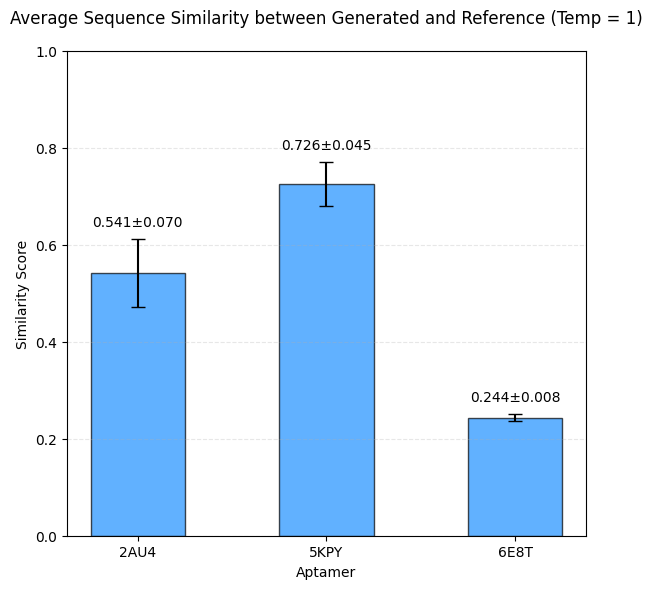

Plot saved as 'similarity_analysis.png'


In [95]:
fig, ax = plt.subplots(figsize=(6, 6))

x_pos = np.arange(len(aptamers))
means = stats['mean'].values
stds = stats['std'].values

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
              color='dodgerblue', edgecolor='black', linewidth=1, width=0.5)

ax.set_xlabel('Aptamer', fontsize=10)
ax.set_ylabel('Similarity Score', fontsize=10)
ax.set_title('Average Sequence Similarity between Generated and Reference (Temp = 1)', 
             fontsize=12, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(aptamers)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{mean:.3f}±{std:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/similarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'similarity_analysis.png'")

In [96]:
print("\n" + "="*80)
print("SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES")
print("="*80 + "\n")

self_similarity_results = []

for aptamer in aptamers:
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate pairwise similarity between all generated sequences
    similarities = []
    for i in range(len(gen_seqs)):
        for j in range(i + 1, len(gen_seqs)):  # Only upper triangle, avoid self-comparison
            similarity = calculate_similarity(gen_seqs[i], gen_seqs[j])
            similarities.append(similarity)
            self_similarity_results.append({
                'Aptamer': aptamer,
                'Seq1': i + 1,
                'Seq2': j + 1,
                'Similarity': similarity
            })
    
    print(f"{aptamer}: {len(similarities)} pairwise comparisons")

# Create DataFrame for self-similarity
df_self = pd.DataFrame(self_similarity_results)

print("\nSelf-Similarity Statistics:")
self_stats = df_self.groupby('Aptamer')['Similarity'].agg(['mean', 'std', 'count'])
print(self_stats)
print("\n")


SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES

2AU4: 190 pairwise comparisons
5KPY: 190 pairwise comparisons
6E8T: 190 pairwise comparisons

Self-Similarity Statistics:
             mean       std  count
Aptamer                           
2AU4     0.619641  0.069073    190
5KPY     0.701408  0.050486    190
6E8T     0.621421  0.042553    190




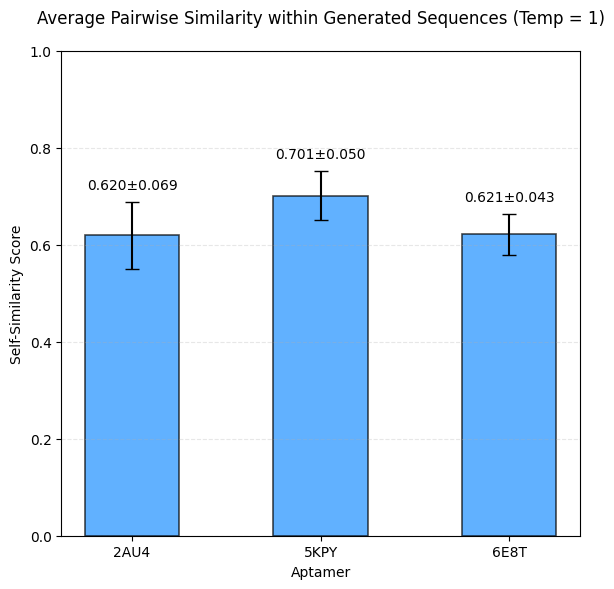

Self-similarity plot saved as 'self_similarity_analysis.png'


In [97]:
# Create bar plot for self-similarity
fig2, ax2 = plt.subplots(figsize=(6, 6))

x_pos = np.arange(len(aptamers))
self_means = self_stats['mean'].values
self_stds = self_stats['std'].values

bars2 = ax2.bar(x_pos, self_means, yerr=self_stds, capsize=5, alpha=0.7, width=0.5,
                color='dodgerblue', edgecolor='black', linewidth=1.2) 

ax2.set_xlabel('Aptamer', fontsize=10)
ax2.set_ylabel('Self-Similarity Score', fontsize=10)
ax2.set_title('Average Pairwise Similarity within Generated Sequences (Temp = 1)', 
              fontsize=12, pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(aptamers)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars with padding above error bars
for i, (bar, mean, std) in enumerate(zip(bars2, self_means, self_stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{mean:.3f}±{std:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/self_similarity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Self-similarity plot saved as 'self_similarity_analysis.png'")

## Temp = 5

In [98]:
# dir with generated seqs
aptamers = ["2AU4", "5KPY", "6E8T"]
base_dir = "./generated_seqs_hightemp/"
fasta_dir = "./aptamers/fasta/"

results = []

# Process each aptamer
for aptamer in aptamers:
    # Read reference sequence
    ref_file = os.path.join(fasta_dir, f"{aptamer}.fasta")
    ref_seqs = read_fasta(ref_file)
    ref_seq = ref_seqs[0] if ref_seqs else ""
    
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate similarity for each generated sequence
    for i, gen_seq in enumerate(gen_seqs):
        similarity = calculate_similarity(ref_seq, gen_seq)
        results.append({
            'Aptamer': aptamer,
            'Sequence': i + 1,
            'Similarity': similarity
        })

# Create DataFrame
df = pd.DataFrame(results)

# Pivot to get desired format (rows = sequences, columns = aptamers)
df_pivot = df.pivot(index='Sequence', columns='Aptamer', values='Similarity')

print("Similarity Matrix:")
print(df_pivot)
print("\n")

# Calculate statistics
stats = df.groupby('Aptamer')['Similarity'].agg(['mean', 'std'])
print("Statistics by Aptamer:")
print(stats)
print("\n")


Similarity Matrix:
Aptamer       2AU4      5KPY      6E8T
Sequence                              
1         0.365854  0.492958  0.237762
2         0.341463  0.394366  0.237762
3         0.365854  0.408451  0.244755
4         0.390244  0.394366  0.244755
5         0.341463  0.436620  0.251748
6         0.365854  0.323944  0.244755
7         0.390244  0.436620  0.237762
8         0.341463  0.422535  0.237762
9         0.317073  0.394366  0.237762
10        0.292683  0.450704  0.251748
11        0.390244  0.436620  0.244755
12        0.414634  0.450704  0.237762
13        0.365854  0.464789  0.244755
14        0.317073  0.394366  0.230769
15        0.463415  0.422535  0.244755
16        0.317073  0.408451  0.237762
17        0.390244  0.422535  0.251748
18        0.365854  0.422535  0.230769
19        0.317073  0.422535  0.244755
20        0.439024  0.408451  0.223776


Statistics by Aptamer:
             mean       std
Aptamer                    
2AU4     0.364634  0.043684
5KPY     0.420

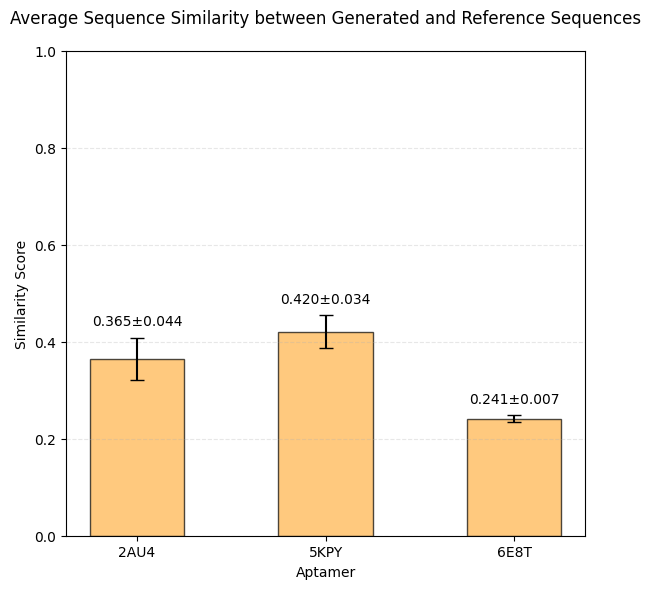

Plot saved as 'similarity_analysis_hightemp.png'


In [99]:
fig, ax = plt.subplots(figsize=(6, 6))

x_pos = np.arange(len(aptamers))
means = stats['mean'].values
stds = stats['std'].values

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
              color='#FFB347', edgecolor='black', linewidth=1, width=0.5)

ax.set_xlabel('Aptamer', fontsize=10)
ax.set_ylabel('Similarity Score', fontsize=10,)
ax.set_title('Average Sequence Similarity between Generated and Reference Sequences', 
             fontsize=12, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(aptamers)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{mean:.3f}±{std:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/similarity_analysis_hightemp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'similarity_analysis_hightemp.png'")

In [100]:
print("\n" + "="*80)
print("SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES")
print("="*80 + "\n")

self_similarity_results = []

for aptamer in aptamers:
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate pairwise similarity between all generated sequences
    similarities = []
    for i in range(len(gen_seqs)):
        for j in range(i + 1, len(gen_seqs)):  # Only upper triangle, avoid self-comparison
            similarity = calculate_similarity(gen_seqs[i], gen_seqs[j])
            similarities.append(similarity)
            self_similarity_results.append({
                'Aptamer': aptamer,
                'Seq1': i + 1,
                'Seq2': j + 1,
                'Similarity': similarity
            })
    
    print(f"{aptamer}: {len(similarities)} pairwise comparisons")

# Create DataFrame for self-similarity
df_self = pd.DataFrame(self_similarity_results)

print("\nSelf-Similarity Statistics:")
self_stats = df_self.groupby('Aptamer')['Similarity'].agg(['mean', 'std', 'count'])
print(self_stats)
print("\n")


SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES

2AU4: 190 pairwise comparisons
5KPY: 190 pairwise comparisons
6E8T: 190 pairwise comparisons

Self-Similarity Statistics:
             mean       std  count
Aptamer                           
2AU4     0.383312  0.053066    190
5KPY     0.387102  0.037016    190
6E8T     0.402576  0.022967    190




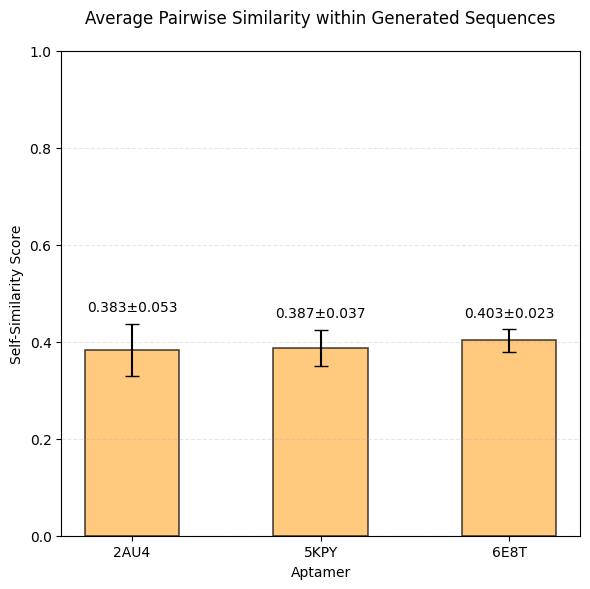

Self-similarity plot saved as 'self_similarity_analysis_hightemp.png'


In [101]:
# Create bar plot for self-similarity
fig2, ax2 = plt.subplots(figsize=(6, 6))

x_pos = np.arange(len(aptamers))
self_means = self_stats['mean'].values
self_stds = self_stats['std'].values

bars2 = ax2.bar(x_pos, self_means, yerr=self_stds, capsize=5, alpha=0.7, width=0.5,
                color='#FFB347', edgecolor='black', linewidth=1.2) 

ax2.set_xlabel('Aptamer', fontsize=10)
ax2.set_ylabel('Self-Similarity Score', fontsize=10)
ax2.set_title('Average Pairwise Similarity within Generated Sequences', 
              fontsize=12, pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(aptamers)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars with padding above error bars
for i, (bar, mean, std) in enumerate(zip(bars2, self_means, self_stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{mean:.3f}±{std:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/self_similarity_analysis_hightemp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Self-similarity plot saved as 'self_similarity_analysis_hightemp.png'")

## Temp = 1e-5

In [102]:
# dir with generated seqs
aptamers = ["2AU4", "5KPY", "6E8T"]
base_dir = "./generated_seqs_lowtemp/"
fasta_dir = "./aptamers/fasta/"

results = []

# Process each aptamer
for aptamer in aptamers:
    # Read reference sequence
    ref_file = os.path.join(fasta_dir, f"{aptamer}.fasta")
    ref_seqs = read_fasta(ref_file)
    ref_seq = ref_seqs[0] if ref_seqs else ""
    
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate similarity for each generated sequence
    for i, gen_seq in enumerate(gen_seqs):
        similarity = calculate_similarity(ref_seq, gen_seq)
        results.append({
            'Aptamer': aptamer,
            'Sequence': i + 1,
            'Similarity': similarity
        })

# Create DataFrame
df = pd.DataFrame(results)

# Pivot to get desired format (rows = sequences, columns = aptamers)
df_pivot = df.pivot(index='Sequence', columns='Aptamer', values='Similarity')

print("Similarity Matrix:")
print(df_pivot)
print("\n")

# Calculate statistics
stats = df.groupby('Aptamer')['Similarity'].agg(['mean', 'std'])
print("Statistics by Aptamer:")
print(stats)
print("\n")

Similarity Matrix:
Aptamer       2AU4      5KPY      6E8T
Sequence                              
1         0.463415  0.760563  0.251748
2         0.463415  0.760563  0.251748
3         0.463415  0.760563  0.251748
4         0.463415  0.760563  0.251748
5         0.463415  0.760563  0.251748
6         0.463415  0.760563  0.251748
7         0.463415  0.760563  0.251748
8         0.463415  0.760563  0.251748
9         0.463415  0.760563  0.251748
10        0.463415  0.760563  0.251748
11        0.463415  0.760563  0.251748
12        0.463415  0.760563  0.251748
13        0.463415  0.760563  0.251748
14        0.463415  0.760563  0.251748
15        0.463415  0.760563  0.251748
16        0.463415  0.760563  0.251748
17        0.463415  0.760563  0.251748
18        0.463415  0.760563  0.251748
19        0.463415  0.760563  0.251748
20        0.463415  0.760563  0.251748


Statistics by Aptamer:
             mean  std
Aptamer               
2AU4     0.463415  0.0
5KPY     0.760563  0.0
6E8T  

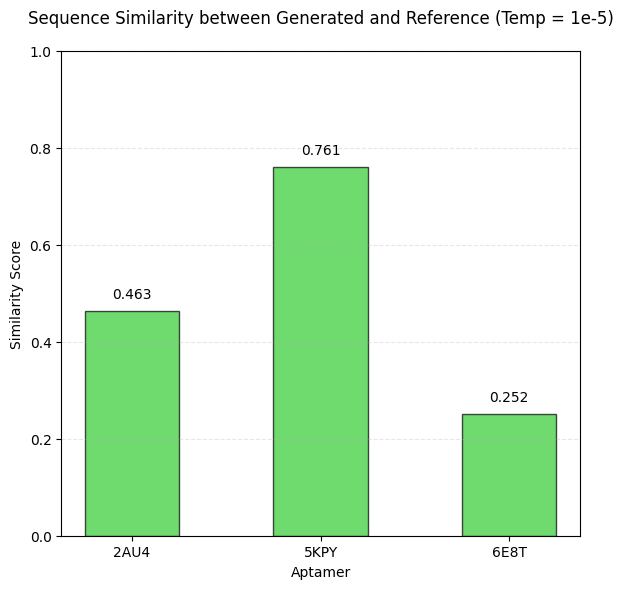

Plot saved as 'similarity_analysis_lowtemp.png'


In [103]:
fig, ax = plt.subplots(figsize=(6, 6))

x_pos = np.arange(len(aptamers))
means = stats['mean'].values
stds = stats['std'].values

bars = ax.bar(x_pos, means,  alpha=0.7, 
              color='limegreen', edgecolor='black', linewidth=1, width=0.5)

ax.set_xlabel('Aptamer', fontsize=10)
ax.set_ylabel('Similarity Score', fontsize=10,)
ax.set_title('Sequence Similarity between Generated and Reference (Temp = 1e-5)', 
             fontsize=12, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(aptamers)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{mean:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/similarity_analysis_lowtemp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'similarity_analysis_lowtemp.png'")

In [104]:
print("\n" + "="*80)
print("SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES")
print("="*80 + "\n")

self_similarity_results = []

for aptamer in aptamers:
    # Read generated sequences
    gen_file = os.path.join(base_dir, aptamer, "aptamers_without2d.fasta")
    gen_seqs = read_fasta(gen_file)
    
    # Calculate pairwise similarity between all generated sequences
    similarities = []
    for i in range(len(gen_seqs)):
        for j in range(i + 1, len(gen_seqs)):  # Only upper triangle, avoid self-comparison
            similarity = calculate_similarity(gen_seqs[i], gen_seqs[j])
            similarities.append(similarity)
            self_similarity_results.append({
                'Aptamer': aptamer,
                'Seq1': i + 1,
                'Seq2': j + 1,
                'Similarity': similarity
            })
    
    print(f"{aptamer}: {len(similarities)} pairwise comparisons")

# Create DataFrame for self-similarity
df_self = pd.DataFrame(self_similarity_results)

print("\nSelf-Similarity Statistics:")
self_stats = df_self.groupby('Aptamer')['Similarity'].agg(['mean', 'std', 'count'])
print(self_stats)
print("\n")


SELF-SIMILARITY ANALYSIS OF GENERATED SEQUENCES

2AU4: 190 pairwise comparisons
5KPY: 190 pairwise comparisons
6E8T: 190 pairwise comparisons

Self-Similarity Statistics:
         mean  std  count
Aptamer                  
2AU4      1.0  0.0    190
5KPY      1.0  0.0    190
6E8T      1.0  0.0    190




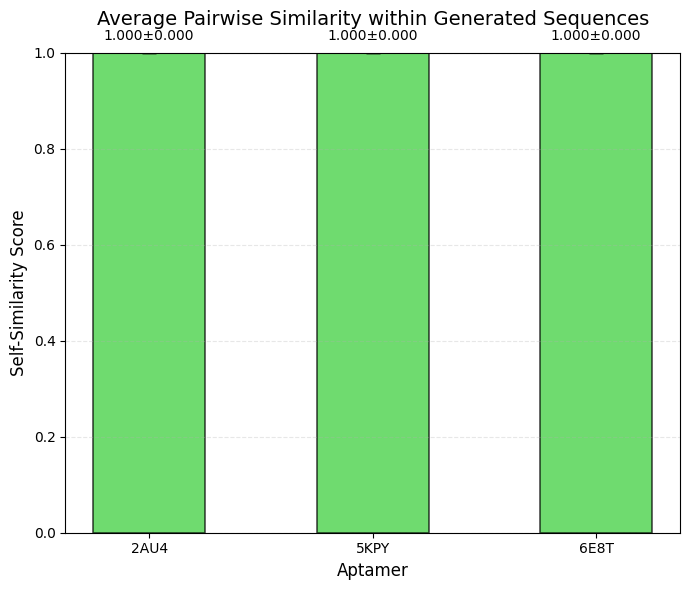

Self-similarity plot saved as 'self_similarity_analysis_lowtemp.png'


In [105]:
# Create bar plot for self-similarity
fig2, ax2 = plt.subplots(figsize=(7, 6))

x_pos = np.arange(len(aptamers))
self_means = self_stats['mean'].values
self_stds = self_stats['std'].values

bars2 = ax2.bar(x_pos, self_means, yerr=self_stds, capsize=5, alpha=0.7, width=0.5,
                color='limegreen', edgecolor='black', linewidth=1.2) 

ax2.set_xlabel('Aptamer', fontsize=12)
ax2.set_ylabel('Self-Similarity Score', fontsize=12)
ax2.set_title('Average Pairwise Similarity within Generated Sequences', 
              fontsize=14, pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(aptamers)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars with padding above error bars
for i, (bar, mean, std) in enumerate(zip(bars2, self_means, self_stds)):
    height = bar.get_height()
    # Add padding above the error bar
    y_pos = height + std + 0.02  # 0.02 units of padding
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{mean:.3f}±{std:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('./figs/self_similarity_analysis_lowtemp.png', dpi=300, bbox_inches='tight')
plt.show()

print("Self-similarity plot saved as 'self_similarity_analysis_lowtemp.png'")